Kress and Carmichael Iron Ratio calculation

[5.78712990e-17 2.30198345e-16 8.63748512e-16 3.06831402e-15
 1.03536137e-14 3.32889426e-14 1.02271700e-13 3.01019965e-13
 8.50884656e-13 2.31502180e-12 6.07506891e-12 1.54062660e-11
 3.78245007e-11 9.00543147e-11 2.08241884e-10 4.68376997e-10
 1.02607062e-09 2.19212567e-09 4.57274945e-09 9.32391068e-09
 1.86029886e-08 3.63545596e-08 6.96512225e-08 1.30939539e-07
 2.41736202e-07 4.38609130e-07]


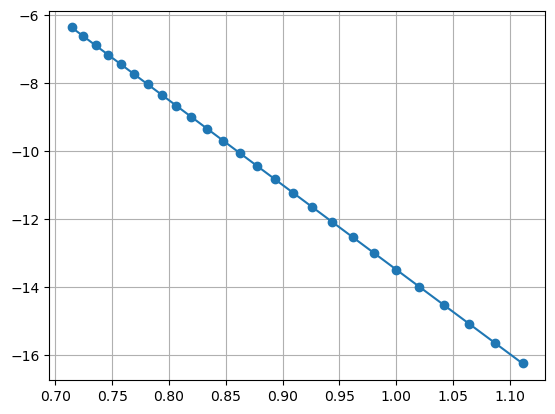

In [83]:
#Oxygen Buffer Reactions
#Cite: B.Fegley, Practical Chemical Thermodynamics for Geoscientists
import numpy as np
import matplotlib.pyplot as plt

#in Bars, at 2000 bars
#at temperature 1273.15K(equal to 1000C)
#using QFM+3 line -- SiO2, Fe2SiO4, Fe3O4 - Quartz, Fayallite, Magnetite

#Existing parameters for QFM
A = 5.5976 
B = 24505.0
C = 0.8099
D = 0.0937
T = np.linspace(900,1400,26)
P = 1

#Specific for the given samples
QFM_PlusThree = 3

Log_fO2 = A - (B/T) + C*np.log10(T) + ((D*(P-1))/T) + QFM_PlusThree
fO2 = 10 ** Log_fO2
print(fO2) #where the array is dependent on the Temperature distribution
plt.plot(1000/np.array(T), Log_fO2, marker = 'o', linestyle = '-')
plt.grid(True)
plt.show()

In [84]:
#K&C p.87 at table 7 Eq.7

In [85]:
#Calculation of the Iron Ratio in the Rock
#using QFM+3 line -- SiO2, Fe2SiO4, Fe3O4 - Quartz, Fayallite, Magnetite
#Kress and Carmichael 1991, Equation 7 and Parameter Values Table 7

#Parameters
a = 0.196
b = 1.1492 * np.power(10, 4)
c = -6.675
d_Al2O3 = -2.243
d_FeOtot = -1.828
d_CaO = 3.201
d_Na2O = 5.854
d_K2O = 6.215
e = -3.36
f = -7.01 * np.power(10.0, -7)
g =1.54 * np.power(10.0, -10)
h = 3.85 * np.power(10.0, -17)
T_0 = 1673 

In [86]:
weight_percent_to_moles = lambda weight_percent, molecular_weight: weight_percent / molecular_weight

molecular_weights = {
    'SiO2': 60.082,
    'TiO2': 79.866,
    'Al2O3': 101.96,
    'FeO': 71.84,
    'MnO': 70.9374,
    'MgO': 40.3044,
    'CaO': 56.08,
    'Na2O': 61.98,
    'K2O': 94.20,
    'P2O5': 283.889
}

weight_percents = {
    'SiO2': 55.08,
    'TiO2' : 0.72,
    'Al2O3': 15.16,
    'FeO': 7.76,
    'MnO': 0.16,
    'MgO': 7.63,
    'CaO': 8.43,
    'Na2O': 3.61,
    'K2O': 0.73,
    'P2O5': 0.16
}

moles = {key: weight_percent_to_moles(weight_percents[key], molecular_weights[key]) for key in weight_percents}
total_moles = sum(moles.values())
mole_fractions = {key: moles[key] / total_moles for key in moles}

SUM_dx = (mole_fractions['Al2O3'] * d_Al2O3) + (mole_fractions['FeO'] * d_FeOtot) + (mole_fractions['CaO'] * d_CaO) + (mole_fractions['Na2O'] * d_Na2O) + (mole_fractions['K2O'] * d_K2O)


In [87]:
#Kress and Carmichael 1991 Equation 7

ln_IronRatio = a*np.log(fO2) + np.divide(b, T) + c + SUM_dx + e*(1 - np.divide(T_0, T) - np.log(np.divide(T, T_0))) + f*np.divide(P, T) + g*np.divide((P*T - P*T_0), T) + h*np.divide(P**2,T)

Text(0, 0.5, 'logfO2')

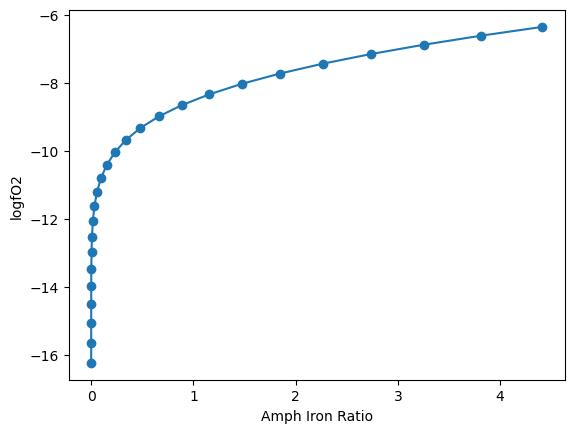

In [88]:
IronRatio = np.power(ln_IronRatio, 10)
K_Iron = np.linspace(0.47,2.33,26)

#Goltz K value range table 3, equation p.2089
Amph_IronRatio = K_Iron * IronRatio
plt.plot(Amph_IronRatio, Log_fO2, marker = 'o')
plt.xlabel("Amph Iron Ratio")
plt.ylabel("logfO2")

code to get the ratio of ferrous to ferric iron is solved for. now we need to take that ratio and apply it to the epma data to determine how much of the iron is ferrous or ferric

In [89]:
import pandas as pd
from fractions import Fraction

file_path = '/Users/tomassalazar/Desktop/Work/Krawcyzski Group/ESPM.Code/Petrology/Kamchatka/EPMA S.2 Analyses/EPMA RAW DATA.2/Tomas Salazar 7-22-2024 samples.xlsx'
sheet_name = '1704'

try:
    data = pd.read_excel(file_path, sheet_name=sheet_name)
except Exception as e:
    print(f"Error reading the Excel file: {e}")
    raise

data.columns = data.columns.str.strip()


#average of the iron amphibole ratio
def Average(Amph_IronRatio):
    return sum(Amph_IronRatio) / len(Amph_IronRatio)

def apply_ratio(whole_number, ratio_numerator, ratio_denominator):
    # Calculate the number of whole parts for numerator and denominator
    numerator_parts = whole_number * ratio_numerator / ratio_denominator
    denominator_parts = whole_number - numerator_parts
    return int(numerator_parts), int(denominator_parts)

Avg_AmphIronRatio = Average(Amph_IronRatio)
ratio = Fraction(Avg_AmphIronRatio).limit_denominator()
numerator = ratio.numerator
denominator = ratio.denominator
FeOtot_Data = data['FeO']

def apply_ratio_to_data(data, numerator, denominator):
    numerator_part = data * numerator / denominator
    denominator_part = data - numerator_part
    return numerator_part, denominator_part

numerator_parts, denominator_parts = apply_ratio_to_data(FeOtot_Data, numerator, denominator)

print(f"Num (FeO data):\n{numerator_parts}")


Num (FeO data):
0     10.700903
1     10.273010
2     10.321820
3     10.362725
4     11.046342
5     10.592804
6     10.422934
7     11.871610
8     11.780792
9      9.961857
10    10.830236
11    10.548865
12    10.803947
13    11.057925
14    12.294815
15    10.291486
16    10.688677
17    12.365686
18    10.262531
19     8.814140
20    10.619461
21    10.208941
22    11.001025
23    10.337998
24    10.924731
25     8.691250
Name: FeO, dtype: float64


Xiaoyan Li, Chao Zhang, Harald Behrens, Francois Holtz 

speadsheet calculation from machine learning

In [107]:
file_path = '/Users/tomassalazar/Desktop/Work/Krawcyzski Group/ESPM.Code/Petrology/Kamchatka/EPMA S.2 Analyses/Misc/amphsitelocator.xlsx'
sheet_name = 'AMPH-SITE-LOCATOR'

try:
    data = pd.read_excel(file_path, sheet_name=sheet_name)
except Exception as e:
    print(f"Error reading the Excel file: {e}")
    raise

data.columns = data.columns.str.strip()
#because the column names cannot be named, the column numbers will be use and the names of them are 'Unnamed: #'
datafeocalc = data['Unnamed: 26'].iloc[1:27]
datafe2O3calc = data['Unnamed: 25'].iloc[1:27]

print(datafeocalc, datafe2O3calc)


1     7.965429
2     7.491492
3     7.693443
4     7.652203
5     8.354323
6     7.883889
7     7.567634
8     8.750066
9     8.719973
10    7.070294
11    7.409012
12    7.931029
13    8.153105
14     8.27936
15     9.24243
16     7.93559
17    8.215982
18    9.509227
19    7.882707
20    5.863495
21    8.046355
22    7.835169
23    8.290368
24    7.908869
25    8.632495
26    4.939144
Name: Unnamed: 26, dtype: object 1     4.085214
2      4.09459
3     3.929167
4     4.024453
5     4.070662
6      4.04514
7     4.191229
8     4.628613
9     4.552257
10    4.186495
11     4.85994
12     3.93963
13    4.001224
14    4.167973
15     4.59309
16    3.623389
17    3.791986
18    4.382274
19    3.647152
20    4.140051
21    3.896815
22    3.635192
23    4.086949
24    3.709317
25    3.614493
26    5.018736
Name: Unnamed: 25, dtype: object


now for the john locock amph iron calculation